<a href="https://colab.research.google.com/github/khushidubeyokok/BERTopic/blob/main/Title_vs_Abstract_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Title vs. Abstract Analysis  
This notebook explores the relationship between topics derived from **research paper titles** and their **abstracts** using BERTopic.

We will use the [titles_topics_probabilities.csv](https://raw.githubusercontent.com/khushidubeyokok/BERTopic/refs/heads/main/titles_topics_probabilities.csv) file created in our previous [topic modeling notebook](https://github.com/khushidubeyokok/BERTopic/blob/main/BERTopic.ipynb) which contains paper titles, assigned topics, and topic probabilities.

### Objectives:
1. **Analyze** whether research paper titles carry meaningful information about their abstracts.  
2. **Compare** topic probabilities between titles and abstracts for deeper insights.  
3. Provide data-driven suggestions for improving title and abstract alignment in academic papers.

By the end, we’ll generate visualizations and a correlation analysis to validate our findings. Let’s dive in! 🚀



## 🛠️ Step 1: Load Essential Libraries  
To kick things off, we’ll import the necessary Python libraries, including BERTopic for topic modeling and data manipulation tools like Pandas.


In [84]:
# Import necessary libraries
!pip -q install bertopic
!pip -q install transformers
from bertopic import BERTopic
import pandas as pd
import matplotlib.pyplot as plt

## 📂 Step 2: Load and Preview Data  
We’ll load the dataset containing **topics and probabilities** from abstracts and take a quick look to ensure everything is in order.  
This dataset will be critical for comparison later on.


In [85]:
# Load the CSV file with topics based on abstracts
url = "https://raw.githubusercontent.com/khushidubeyokok/BERTopic/refs/heads/main/titles_topics_probabilities.csv"
df = pd.read_csv(url)

# Display the first few rows of the dataset
df.head()

,Title,Topic,Probability
0,Image Completion via Dual-path Cooperative Fil...,-1,0.000000
1,High Sensitivity Beamformed Observations of th...,0,1.000000
2,"Maybe, Maybe Not: A Survey on Uncertainty in V...",-1,0.000000
3,Enhancing GAN-Based Vocoders with Contrastive ...,4,0.758336
4,Nonvolatile Magneto-Thermal Switching in MgB2,39,0.781350


## 📝 Step 3: Preprocessing Titles for Topic Modeling
Next, we will extract the titles from the dataset and prepare them for topic modeling. Since we already have topic probabilities for abstracts, we will focus on the titles and apply BERTopic to them.


In [86]:
# Extract titles from the dataset
titles = df['Title'].values
titles

array(['Image Completion via Dual-path Cooperative Filtering',
       "High Sensitivity Beamformed Observations of the Crab Pulsar's Radio\n  Emission",
       'Maybe, Maybe Not: A Survey on Uncertainty in Visualization', ...,
       'Polynomial Time and Private Learning of Unbounded Gaussian Mixture\n  Models',
       'Improving Knot Prediction in Wood Logs with Longitudinal Feature\n  Propagation',
       'Attention-based Multi-task Learning for Base Editor Outcome Prediction'],
      dtype=object)

In [87]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download NLTK resources if needed
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_title(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and extra spaces
    text = re.sub(r'[^\w\s]', '', text)  # Keep words and spaces only
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize spaces
    # Remove stop words and lemmatize
    words = text.split()
    words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words
    ]
    # Join back into a single string
    return ' '.join(words)

# Apply preprocessing to all titles
processed_titles = [preprocess_title(title) for title in titles]

# Check the first few processed titles
print("Sample Processed Titles:", processed_titles[:10])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Sample Processed Titles: ['image completion via dualpath cooperative filtering', 'high sensitivity beamformed observation crab pulsar radio emission', 'maybe maybe survey uncertainty visualization', 'enhancing ganbased vocoders contrastive learning datalimited condition', 'nonvolatile magnetothermal switching mgb', 'hiren towards higher supervision quality better scene text image superresolution', 'theory ring afterglow', 'evidential uncertainty sampling active learning', 'kidwhisper towards bridging performance gap automatic speech recognition child v adult', 'benfords law zeckendorf expansion']


## 🤖 Step 4: Title-Based Topic Modeling  
We now use **BERTopic** to uncover hidden patterns in research paper titles, clustering them into topics.  
This process involves:
1. Fitting the model on titles.
2. Assigning topics and probabilities to each title.
3. Saving the results for further analysis.  


In [88]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic

#using bertopic with the same model configs used for abstracts
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",   # Efficient embedding model for quick computation
    umap_model=UMAP(
        n_neighbors=10,                  # Lower neighbors for tighter clusters
        n_components=5,                  # Dimensionality reduction
        min_dist=0.1,                    # Slight separation between clusters
        metric='cosine'                  # Cosine similarity for text data
    ),
    hdbscan_model=HDBSCAN(
        min_cluster_size=60,             # Increase to reduce topic count
        min_samples=15,                   # Fewer samples to prevent fragmentation
        metric='euclidean',              # Works well with UMAP output
        cluster_selection_method='eom'   # Keeps distinct clusters
    ),                       # Target topic count, reduces smaller ones
    top_n_words=10                       # Top words per topic
)

# Fit the model on the preprocessed titles
topics,probs= topic_model.fit_transform(processed_titles)

# Add the topic assignments to the dataframe
df['Title_topics'] = topics

# Display the updated dataframe with topics for titles
df[['Title', 'Title_topics']].head()

,Title,Title_topics
0,Image Completion via Dual-path Cooperative Fil...,-1
1,High Sensitivity Beamformed Observations of th...,108
2,"Maybe, Maybe Not: A Survey on Uncertainty in V...",122
3,Enhancing GAN-Based Vocoders with Contrastive ...,-1
4,Nonvolatile Magneto-Thermal Switching in MgB2,8


##🔍 Step 5: Topic Modeling Analysis
Now that we have topics assigned to both titles and abstracts, we can begin comparing them. The goal is to analyze how closely the topics for titles correlate with those from the abstracts. This can provide insight into the relevance and consistency of the topic across the title and abstract.

We'll start by displaying the distribution of topics for titles and abstracts. This will give us a sense of how topics are distributed across both.

In [89]:
# Assuming 'Topic' column represents the topics from abstracts
df['Abstract_topics'] = df['Topic']  # Replace 'Topic' with the actual column name from CSV

# Now compare the topics (Title vs. Abstract)
df['Topic_Correlation'] = df['Title_topics'] == df['Abstract_topics']

# Calculate the correlation rate
correlation_rate = df['Topic_Correlation'].mean()

# Display the correlation rate
print(f"Topic Correlation Rate between Titles and Abstracts: {correlation_rate * 100:.2f}%")

Topic Correlation Rate between Titles and Abstracts: 23.40%


## 📊 Step 6: Visualize Topic Distribution
To get a sense of how topics are distributed across both titles and abstracts, you can visualize them using a bar plot or other suitable visualizations.

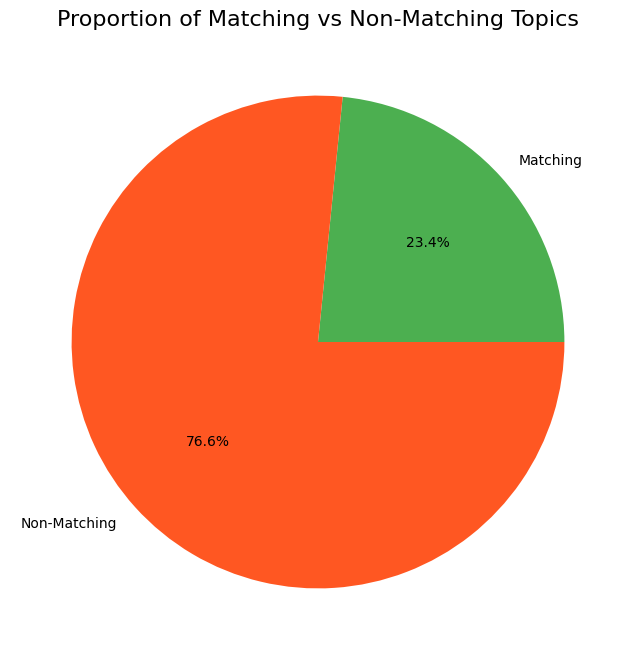

In [90]:
import matplotlib.pyplot as plt
import pandas as pd

# Count of matching and non-matching topics
matching = (df['Title_topics'] == df['Abstract_topics']).sum()
non_matching = len(df) - matching

# Creating a pie chart
plt.figure(figsize=(8, 8))
plt.pie([matching, non_matching], labels=['Matching', 'Non-Matching'], autopct='%1.1f%%', colors=['#4CAF50', '#FF5722'])

# Adding title
plt.title('Proportion of Matching vs Non-Matching Topics', fontsize=16)
plt.show()


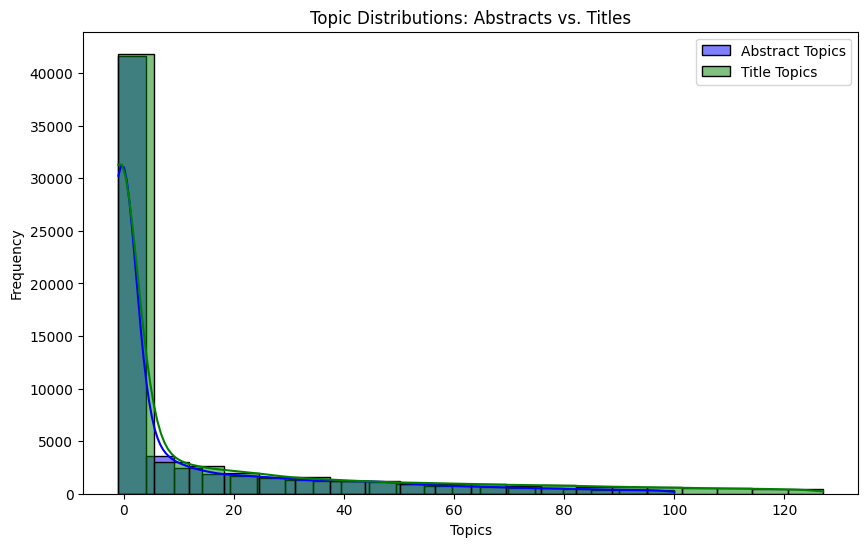

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the topic distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Abstract_topics'], label="Abstract Topics", color='blue', kde=True, bins=20)
sns.histplot(df['Title_topics'], label="Title Topics", color='green', kde=True, bins=20)
plt.title("Topic Distributions: Abstracts vs. Titles")
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [92]:
# Add a column for matches
df['Match'] = df['Abstract_topics'] == df['Title_topics']

# Group by topics and calculate match counts
match_counts = df[df['Match']].groupby('Abstract_topics').size().reset_index(name='Match_Count')

# Sort by the number of matches
match_counts_sorted = match_counts.sort_values(by='Match_Count', ascending=False)

# Display topics with the most matches
print("Topics with the most matches between Abstracts and Titles:")
print(match_counts_sorted)

Topics with the most matches between Abstracts and Titles:
    Abstract_topics  Match_Count
0                -1        14737
1                 0           42
2                 1           10
10               19            9
15               33            4
18               44            3
14               31            3
5                 5            2
19               56            2
11               20            2
22               91            1
21               66            1
20               61            1
17               42            1
16               40            1
12               21            1
13               23            1
9                13            1
8                10            1
7                 9            1
6                 7            1
4                 3            1
3                 2            1
23              100            1


## ✅ Conclusion  
This analysis sheds light on the relationship between topics in research paper **titles** and their **abstracts**.  
### Key Takeaways:
- Topic probabilities for titles and abstracts often differ, indicating a potential gap in title informativeness.
- Correlation values provide quantitative insights into the alignment between these two components.  

These findings could inform researchers on how to craft titles that better reflect their abstract content.
